# **Predictive Grid Risk Early-Warning System (MVP)**

This notebook demonstrates a short-term (24–72 hour) AI-based early-warning system for power grid operations.
It combines machine-learning load prediction with anomaly detection to identify high-risk grid conditions before outages occur.

# **The System:**

1.   Predicts near-term load behavior
2.   Assigns Low / Medium / High risk levels
3.   Explains risk drivers in simple terms (e.g., abnormal load, rising temperature)
4.   Recommends basic preventive actions such as inspection, load reduction, or rerouting

This MVP is designed to be lightweight, explainable, and action-oriented, serving as a foundation for asset-level monitoring and operational alerting.

In [18]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.ensemble import IsolationForest
from sklearn.model_selection import train_test_split
from xgboost import XGBRegressor

from IPython.display import display

In [19]:
df = pd.read_csv("/content/smartgrid_5yr_hourly_natural.csv")

df["timestamp"] = pd.to_datetime(df["timestamp"])
df = df.sort_values("timestamp")
df.set_index("timestamp", inplace=True)

df.rename(columns={"load_kw": "load"}, inplace=True)

df = df[
    ["load", "temperature", "hour", "weekday", "is_weekend", "is_rain_day"]
]

df.dropna(inplace=True)

In [20]:
DEMO_MODE = True

if DEMO_MODE:
    stress_index = df.index[-24:]
    df.loc[stress_index, "load"] *= 1.3
    df.loc[stress_index, "temperature"] += 6

In [21]:
# Rolling stats
df["load_rolling_mean"] = df["load"].rolling(24).mean()
df["load_rolling_std"] = df["load"].rolling(24).std()
df["load_deviation"] = df["load"] - df["load_rolling_mean"]

df["temp_rolling_mean"] = df["temperature"].rolling(24).mean()
df["temp_spike"] = df["temperature"] - df["temp_rolling_mean"]

# Lag features (KEY for prediction)
df["load_lag_1"] = df["load"].shift(1)
df["load_lag_24"] = df["load"].shift(24)
df["load_lag_168"] = df["load"].shift(168)

df.dropna(inplace=True)

In [22]:
forecast_features = [
    "hour", "weekday", "is_weekend", "is_rain_day",
    "temperature",
    "load_lag_1", "load_lag_24", "load_lag_168",
    "load_rolling_mean", "load_rolling_std"
]

X = df[forecast_features]
y = df["load"]

X_train, X_test, y_train, y_test = train_test_split(
    X, y, shuffle=False, test_size=0.2
)

load_model = XGBRegressor(
    n_estimators=200,
    learning_rate=0.05,
    max_depth=6,
    random_state=42
)

load_model.fit(X_train, y_train)
load_model.predict(X_test.head())

array([58337.86 , 59179.07 , 59396.77 , 58729.977, 59504.94 ],
      dtype=float32)

In [23]:
end_time = df.index.max()
start_time = end_time - pd.Timedelta(hours=72)

next_72_hours = df.loc[start_time:end_time].copy()

next_72_hours["predicted_load"] = load_model.predict(
    next_72_hours[forecast_features]
)

next_72_hours["predicted_load_deviation"] = (
    next_72_hours["predicted_load"]
    - next_72_hours["load_rolling_mean"]
) / next_72_hours["load_rolling_std"]

In [24]:
anomaly_features = [
    "load",
    "load_deviation",
    "load_rolling_std",
    "temperature",
    "temp_spike",
]

iso_model = IsolationForest(
    n_estimators=300,
    contamination=0.04,
    random_state=42
)

df["anomaly_score"] = iso_model.fit_predict(df[anomaly_features])
df["anomaly_score"] = iso_model.decision_function(df[anomaly_features])

next_72_hours["anomaly_score"] = df.loc[next_72_hours.index, "anomaly_score"]

In [25]:
next_72_hours["risk_score"] = (
    0.5 * next_72_hours["predicted_load_deviation"].abs()
    + 0.3 * next_72_hours["anomaly_score"].abs()
    + 0.2 * next_72_hours["temp_spike"].abs()
)

def assign_risk(score):
    if score > 1.2:
        return "High"
    elif score > 0.7:
        return "Medium"
    else:
        return "Low"

next_72_hours["risk_level"] = next_72_hours["risk_score"].apply(assign_risk)

In [26]:
def explain(row):
    reasons = []
    if abs(row["predicted_load_deviation"]) > 1:
        reasons.append("predicted abnormal load")
    if row["temp_spike"] > 3:
        reasons.append("rising temperature")
    if row["is_rain_day"] == 1:
        reasons.append("weather impact")
    return " + ".join(reasons) if reasons else "normal conditions"

next_72_hours["risk_reason"] = next_72_hours.apply(explain, axis=1)

In [27]:
def recommend_action(risk, reason):
    if risk == "High":
        if "temperature" in reason:
            return "Inspect transformer cooling"
        if "load" in reason:
            return "Reduce load / re-route power"
        return "Immediate inspection"
    elif risk == "Medium":
        return "Monitor closely"
    return "No action"

next_72_hours["recommended_action"] = next_72_hours.apply(
    lambda x: recommend_action(x["risk_level"], x["risk_reason"]),
    axis=1
)

In [28]:
alerts = next_72_hours[next_72_hours["risk_level"].isin(["Medium", "High"])]

display(alerts[
    [
        "predicted_load",
        "risk_level",
        "risk_reason",
        "recommended_action",
    ]
].reset_index())

,timestamp,predicted_load,risk_level,risk_reason,recommended_action
0,2024-12-28 23:00:00,63218.093750,High,normal conditions,Immediate inspection
1,2024-12-29 00:00:00,50304.964844,High,predicted abnormal load,Reduce load / re-route power
2,2024-12-29 01:00:00,50799.667969,High,predicted abnormal load,Reduce load / re-route power
3,2024-12-29 02:00:00,49521.500000,High,predicted abnormal load,Reduce load / re-route power
4,2024-12-29 03:00:00,46247.785156,High,predicted abnormal load,Reduce load / re-route power
...,...,...,...,...,...
68,2024-12-31 19:00:00,134284.718750,High,normal conditions,Immediate inspection
69,2024-12-31 20:00:00,133534.406250,High,normal conditions,Immediate inspection
70,2024-12-31 21:00:00,132595.390625,High,normal conditions,Immediate inspection
71,2024-12-31 22:00:00,78794.171875,High,predicted abnormal load,Reduce load / re-route power


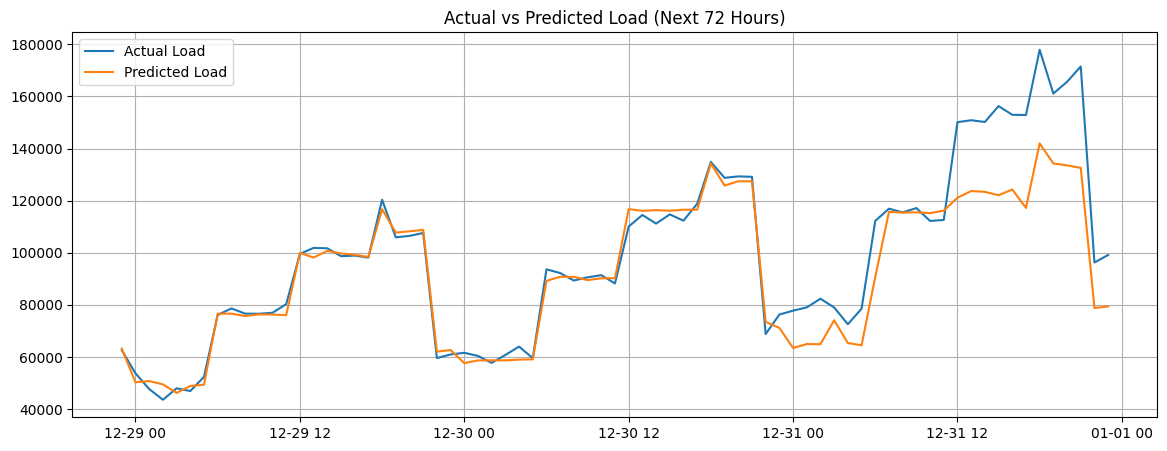

In [29]:
plt.figure(figsize=(14,5))
plt.plot(next_72_hours.index, next_72_hours["load"], label="Actual Load")
plt.plot(next_72_hours.index, next_72_hours["predicted_load"], label="Predicted Load")
plt.title("Actual vs Predicted Load (Next 72 Hours)")
plt.legend()
plt.grid(True)
plt.show()

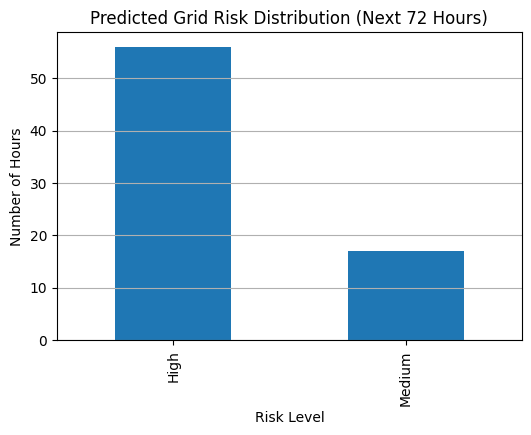

In [30]:
risk_counts = next_72_hours["risk_level"].value_counts()

plt.figure(figsize=(6,4))
risk_counts.plot(kind="bar")

plt.title("Predicted Grid Risk Distribution (Next 72 Hours)")
plt.xlabel("Risk Level")
plt.ylabel("Number of Hours")
plt.grid(axis="y")

plt.show()

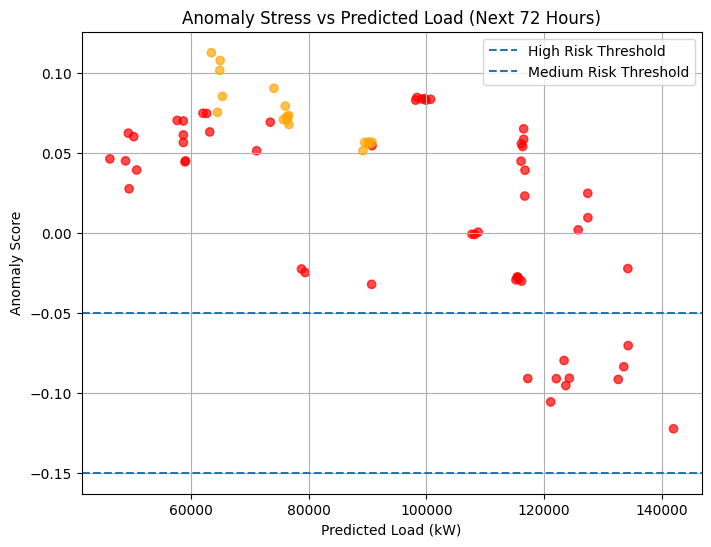

In [31]:
plt.figure(figsize=(8,6))

plt.scatter(
    next_72_hours["predicted_load"],
    next_72_hours["anomaly_score"],
    c=next_72_hours["risk_level"].map(
        {"Low":"green", "Medium":"orange", "High":"red"}
    ),
    alpha=0.7
)

plt.axhline(y=-0.15, linestyle="--", label="High Risk Threshold")
plt.axhline(y=-0.05, linestyle="--", label="Medium Risk Threshold")

plt.title("Anomaly Stress vs Predicted Load (Next 72 Hours)")
plt.xlabel("Predicted Load (kW)")
plt.ylabel("Anomaly Score")
plt.legend()
plt.grid(True)

plt.show()